<a href="https://colab.research.google.com/github/venuendluri/Waste-sorting/blob/main/Copy_of_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch albumentations tqdm torch torchvision

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=a10dffdcdb5e66282d7a064e3c479e48faf4e1b1cc44c8716

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import torch.cuda.amp as amp

# Define Focal Loss (for imbalanced classes)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=6): # Changed _init_ to __init__
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)
        loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()

# Augmentations with Albumentations
transform = A.Compose([
    A.Resize(224, 224),  # Ensure all images are resized to 224x224
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5, rotate_limit=20),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Custom Dataset Class to apply Albumentations
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None): # Changed _init_ to __init__
        self.dataset = dataset
        self.transform = transform

    def __len__(self): # Changed _len_ to __len__
        return len(self.dataset)

    def __getitem__(self, idx): # Changed _getitem_ to __getitem__
        img, label = self.dataset[idx]
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

# Data Preparation
data_dir = "/content/drive/MyDrive/dataset-resized"
dataset = ImageFolder(data_dir)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_data = AlbumentationsDataset(train_data, transform=transform)
val_data = AlbumentationsDataset(val_data, transform=transform)
test_data = AlbumentationsDataset(test_data, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define EfficientNetB3 Model with fine-tuning
class EfficientNetB3Classifier(nn.Module):
    def __init__(self, num_classes):  # Changed _init_ to __init__
        super(EfficientNetB3Classifier, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b3')  # Use EfficientNetB3
        in_features = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.efficient_net(x)

# Initialize model, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB3Classifier(num_classes=6).to(device)  # Updated to EfficientNetB3
criterion = FocalLoss(alpha=0.25, gamma=2, num_classes=6)
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Save and Load Checkpoints
def save_checkpoint(model, optimizer, scheduler, epoch, path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, scheduler, path="checkpoint.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, scheduler, start_epoch

# Mixup Functions
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0): # Changed _init_ to __init__
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss): # Changed _call_ to __call__
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, start_epoch=0, checkpoint_path="checkpoint.pth"):
    early_stopping = EarlyStopping(patience=5, delta=0.01)
    scaler = torch.cuda.amp.GradScaler()  # Mixed Precision

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)
            optimizer.zero_grad()

            with amp.autocast():  # Mixed Precision
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Accuracy: {train_accuracy:.2f}%")

        # Validation Phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)
        scheduler.step()

# Resume Training if Checkpoint Exists
checkpoint_path = "checkpoint.pth"
start_epoch = 0
if os.path.exists(checkpoint_path):
    model, optimizer, scheduler, start_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
    print(f"Resumed training from epoch {start_epoch}")

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, start_epoch=start_epoch, checkpoint_path=checkpoint_path)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-1-1e4f95ea7762>:143: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Loaded pretrained weights for efficientnet-b3


Epoch 1/50:   0%|          | 0/56 [00:00<?, ?it/s]<ipython-input-1-1e4f95ea7762>:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():  # Mixed Precision
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/50 | Loss: 0.1996 | Train Accuracy: 52.90%
Validation Loss: 0.0872 | Validation Accuracy: 80.23%


Epoch 2/50 | Loss: 0.1547 | Train Accuracy: 64.53%
Validation Loss: 0.0891 | Validation Accuracy: 77.10%


Epoch 3/50 | Loss: 0.1383 | Train Accuracy: 66.72%
Validation Loss: 0.0885 | Validation Accuracy: 79.06%


Epoch 4/50 | Loss: 0.1252 | Train Accuracy: 70.73%
Validation Loss: 0.0549 | Validation Accuracy: 87.28%


Epoch 5/50 | Loss: 0.1199 | Train Accuracy: 70.79%
Validation Loss: 0.0413 | Validation Accuracy: 90.41%


Epoch 6/50 | Loss: 0.0988 | Train Accuracy: 77.69%
Validation Loss: 0.0384 | Validation Accuracy: 90.80%


Epoch 7/50 | Loss: 0.1090 | Train Accuracy: 72.24%
Validation Loss: 0.0378 | Validation Accuracy: 92.17%


Epoch 8/50 | Loss: 0.1046 | Train Accuracy: 71.66%
Validation Loss: 0.0351 | Validation Accuracy: 91.39%


Epoch 9/50 | Loss: 0.1012 | Train Accuracy: 73.65%
Validation Loss: 0.0367 | Validation Accuracy: 91.59%


Epoch 10/50 | Loss: 0.0921 | Train Accuracy: 75.51%
Validation Loss: 0.0318 | Validation Accuracy: 94.32%
Early stopping triggered


In [ ]:
pip install scikit-learn



Classification Report:
               precision    recall  f1-score   support

   cardboard       1.00      0.96      0.98        48
       glass       0.95      0.95      0.95        43
       metal       0.96      0.98      0.97        46
       paper       0.97      0.98      0.98        60
     plastic       0.98      0.96      0.97        45
       trash       0.94      1.00      0.97        15

    accuracy                           0.97       257
   macro avg       0.97      0.97      0.97       257
weighted avg       0.97      0.97      0.97       257


Confusion Matrix:
 [[46  0  0  2  0  0]
 [ 0 41  1  0  1  0]
 [ 0  0 45  0  0  1]
 [ 0  0  1 59  0  0]
 [ 0  2  0  0 43  0]
 [ 0  0  0  0  0 15]]


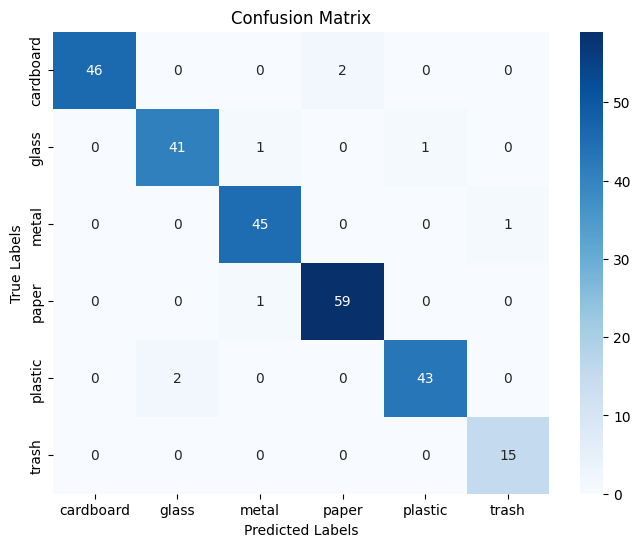

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute classification report
    report = classification_report(all_targets, all_preds, target_names=class_names)
    print("\nClassification Report:\n", report)

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    print("\nConfusion Matrix:\n", cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names from the dataset
class_names = dataset.classes

# Evaluate model on test set
evaluate_model(model, test_loader, class_names)


In [ ]:
import numpy as np
import pandas as pd

# Given Confusion Matrix
conf_matrix = np.array([
    [46,  0,  0,  2,  0,  0],
    [ 0, 41,  1,  0,  1,  0],
    [ 0,  0, 45,  0,  0,  1],
    [ 0,  0,  1, 59,  0,  0],
    [ 0,  2,  0,  0, 43,  0],
    [ 0,  0,  0,  0,  0, 15]
])

# Class Names
class_names = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

num_classes = conf_matrix.shape[0]

# Metrics Calculation
metrics = []
for i in range(num_classes):
    TP = conf_matrix[i, i]  # True Positives
    FP = conf_matrix[:, i].sum() - TP  # False Positives
    FN = conf_matrix[i, :].sum() - TP  # False Negatives
    TN = conf_matrix.sum() - (TP + FP + FN)  # True Negatives

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / conf_matrix.sum()

    metrics.append([precision, recall, specificity, f1_score, accuracy])

# Convert to Pandas DataFrame
columns = ["Precision", "Recall", "Specificity", "F1-Score", "Accuracy"]
df = pd.DataFrame(metrics, columns=columns)
df.index = class_names  # Use class names as index

# Display the Table
print(df)


           Precision    Recall  Specificity  F1-Score  Accuracy
Cardboard   1.000000  0.958333     1.000000  0.978723  0.992218
Glass       0.953488  0.953488     0.990654  0.953488  0.984436
Metal       0.957447  0.978261     0.990521  0.967742  0.988327
Paper       0.967213  0.983333     0.989848  0.975207  0.988327
Plastic     0.977273  0.955556     0.995283  0.966292  0.988327
Trash       0.937500  1.000000     0.995868  0.967742  0.996109


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Given confusion matrix
conf_matrix = np.array([
    [46,  0,  0,  2,  0,  0],
    [ 0, 41,  1,  0,  1,  0],
    [ 0,  0, 45,  0,  0,  1],
    [ 0,  0,  1, 59,  0,  0],
    [ 0,  2,  0,  0, 43,  0],
    [ 0,  0,  0,  0,  0, 15]
])

# Calculate per-class metrics
TP = np.diag(conf_matrix)  # True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

# Compute Precision, Recall, Specificity, and F1-Score
precision = TP / (TP + FP + 1e-6)  # Adding epsilon to avoid division by zero
recall = TP / (TP + FN + 1e-6)
specificity = TN / (TN + FP + 1e-6)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Compute overall accuracy
accuracy = np.sum(TP) / np.sum(conf_matrix)

# Create a DataFrame for display
metrics_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "Specificity", "F1-Score", "Accuracy"],
    "Value": [
        np.mean(precision),
        np.mean(recall),
        np.mean(specificity),
        np.mean(f1_score),
        accuracy
    ]
})

# Display the table
print(metrics_df)

        Metric     Value
0    Precision  0.965487
1       Recall  0.971495
2  Specificity  0.993696
3     F1-Score  0.968199
4     Accuracy  0.968872


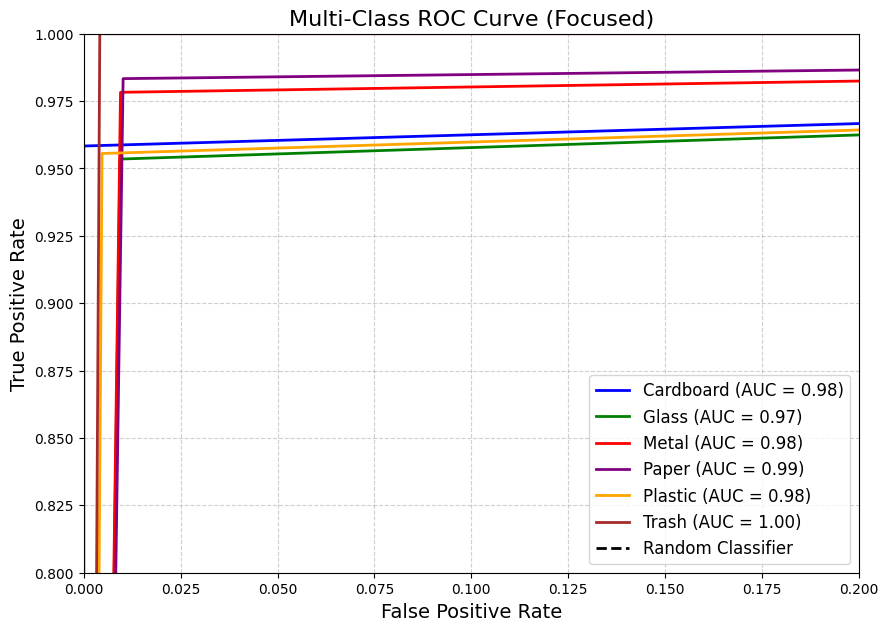

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Given confusion matrix
conf_matrix = np.array([
    [46,  0,  0,  2,  0,  0],
    [ 0, 41,  1,  0,  1,  0],
    [ 0,  0, 45,  0,  0,  1],
    [ 0,  0,  1, 59,  0,  0],
    [ 0,  2,  0,  0, 43,  0],
    [ 0,  0,  0,  0,  0, 15]
])

# Calculate per-class metrics
TP = np.diag(conf_matrix)  # True Positives
FP = np.sum(conf_matrix, axis=0) - TP  # False Positives
FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives
TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

# Compute Precision, Recall, Specificity, and F1-Score
precision = TP / (TP + FP + 1e-6)  # Adding epsilon to avoid division by zero
recall = TP / (TP + FN + 1e-6)
specificity = TN / (TN + FP + 1e-6)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Compute overall accuracy
accuracy = np.sum(TP) / np.sum(conf_matrix)

# Create a DataFrame for display
metrics_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "Specificity", "F1-Score", "Accuracy"],
    "Value": [
        np.mean(precision),
        np.mean(recall),
        np.mean(specificity),
        np.mean(f1_score),
        accuracy
    ]
})

# Display the table
print(metrics_df)